### 0. Import libraries & functions

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0";
#from pudb import set_trace
import numpy as np
import torch
from torchvision import models

import torch.backends.cudnn as cudnn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from utils_rb import *
from ramboattack import RamBoAtt
from HSJA_rb import HSJA
from SignOPT_rb import OPT_attack_sign_SGD

In [2]:
def imshow(img):
    
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

In [3]:
def perturbation_heat_map(xo,xa):
    
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    x=torch.abs(xo-xa).sum(dim=1).cpu()[0]
    sns.heatmap(x,ax=ax,xticklabels=False, yticklabels=False,cbar = False)
    plt.show()

### 1. Load data, pretrained model, evaluation set

In [4]:
# a. Load dataset

batch_size = 1
dataset = 'cifar10' 
datapath = '../datasets/cifar10'
testloader, testset = load_data(dataset,data_path=datapath,batch_size=batch_size)

Files already downloaded and verified


In [5]:
# b. Load pre-trained model

# 'resnet50' if pre-trained model from Pytorch. 'cifar10' if using pre-trained cifar10 model
arch = 'cifar10' 

# None means using pre-traineded model from Pytorch or default path. Otherwise, please change model_path = '...'
model_path = None 

# True means pre-trained model does "not" normalized data while training, 
# so no need to unnorm during intergerence (used for CIFAR10 model)

if dataset == 'cifar10':
    num_classes = 10
    unnorm = True # True means pre-trained model does "not" normalized data while training.
    
net = load_model(arch,model_path)
model_rb = PretrainedModel(net,dataset,unnorm)

bounds = [0,1]
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)

In [6]:
# c. Load evaluation set
targeted = True # True means targeted attack. False means untargeted attack.
# 'balance', 'easyset'->imagenet or cifar10; 
# 'hardset'-> imagenet; 
# 'hardset_A','hardset_B','hardset_D' -> cifar10
eval_set =  'hardset_B'

ID_set = get_evalset(dataset,targeted,eval_set)

### 2. HopSkipJump Evaluation

In [7]:
i = 2 #0,1,2,10,20, 50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
if dataset == 'cifar10':
    delta = 1e-2
    len_T = 500

constraint='l2'
num_iterations=150
gamma=1.0
stepsize_search='geometric_progression'
max_num_evals = 1e4
init_num_evals=100
verbose=True
auto_terminate=False

#seed = 0
#np.random.seed(seed)

In [8]:
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module = HSJA(model_ex,constraint,num_iterations,gamma,stepsize_search,max_num_evals,init_num_evals, verbose,delta,len_T)
if targeted:
    adv, nqry, Dt = module.hsja(oimg.cpu().numpy(), y_targ, timg.cpu().numpy(),targeted,query_limit,auto_terminate)
else:
    timg = None
    adv, nqry, Dt = module.hsja(oimg.cpu().numpy(), y_targ, timg,targeted,auto_terminate)
    
adv = torch.unsqueeze(torch.from_numpy(adv).float(), 0).cuda()

iteration: 1, l2 distance 1.1526E+01 - nqry:139
iteration: 11, l2 distance 2.8740E+00 - nqry:2808
iteration: 21, l2 distance 1.5103E+00 - nqry:7076
iteration: 31, l2 distance 1.5022E+00 - nqry:12494
iteration: 41, l2 distance 1.5005E+00 - nqry:18824
iteration: 51, l2 distance 1.2988E+00 - nqry:25906
iteration: 61, l2 distance 1.2571E+00 - nqry:33665
iteration: 71, l2 distance 1.2545E+00 - nqry:42100

Break due to over query limit!



Source image:


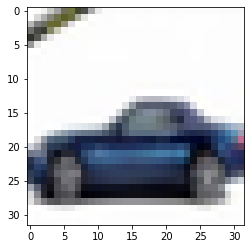

Starting image:


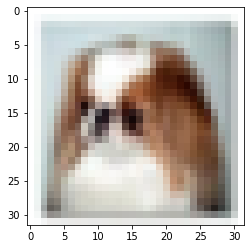

Adversarial Example:


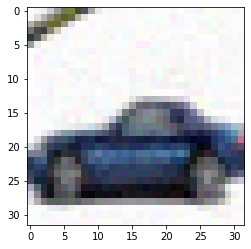

Perturbation Heat Map:


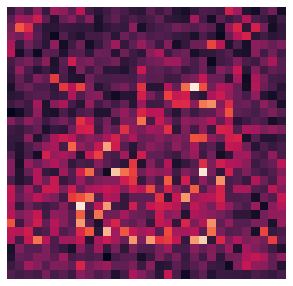

In [9]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [10]:
DHsja = Dt

### 3. Sign-OPT Evaluation

In [13]:
i = 2#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
alpha = 0.2
beta = 0.001
iterations = 5000
distortion = None
stopping = 0.0001
auto_terminate=False
k=200

seed = 0
#np.random.seed(seed)

if dataset == 'cifar10':
    delta = 1e-2
    len_T = 2
elif dataset == 'imagenet':
    delta = 1
    len_T = 4

module = OPT_attack_sign_SGD(model_rb,k,delta,len_T,testset)

In [14]:
if targeted:
    adv, nqry, Dt = module.attack_targeted(oimg, olabel, timg, tlabel, alpha, beta, iterations, query_limit, distortion, seed, stopping, auto_terminate)

Targeted attack - Source: 1 and Target: 5 - pred y0: tensor([1], device='cuda:0') - pred yt: tensor([5], device='cuda:0')
--------> Found distortion 11.6200
==========> Found best distortion 11.6200 in 0.0350 seconds using 22 queries
Iteration   1 distortion 9.2015 num_queries 373
Iteration  11 distortion 3.9571 num_queries 4240
Iteration  21 distortion 3.4252 num_queries 7691
Iteration  31 distortion 3.1196 num_queries 11343
Iteration  41 distortion 3.0244 num_queries 14772
Iteration  51 distortion 2.9568 num_queries 18012
Iteration  61 distortion 2.9155 num_queries 21405
Iteration  71 distortion 2.8279 num_queries 25476
Iteration  81 distortion 2.4322 num_queries 34157
Iteration  91 distortion 2.3741 num_queries 40034
Iteration 101 distortion 2.0139 num_queries 47068
break due to query cnt > query limit 51310

Adversarial Example Found Successfully: distortion 1.9837 target 5 queries 51310 LS queries 30088 
Time: 100.1367 seconds


Source image:


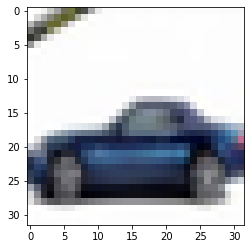

Starting image:


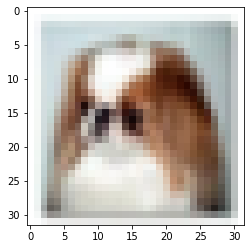

Adversarial Example:


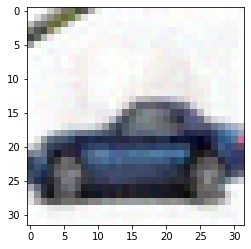

Perturbation Heat Map:


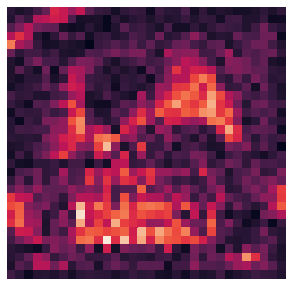

In [15]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [16]:
DSopt = Dt

### 4. RamBoAttack Evaluation

### 4a. RamBoAttack (HSJA) Evaluation

In [17]:
i = 2#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [18]:
attack_mode = 'RBH' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 50000

model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

iteration: 1, l2 distance 9.4617E+00 - nqry:140
iteration: 11, l2 distance 3.2992E+00 - nqry:2821
iteration: 21, l2 distance 2.3422E+00 - nqry:7093

Break due to slow convergence!

Module 1: Finished HSJA

Qry# 0 ; l2 distance = 2.339737892150879 ; adv label: 5


/home/viet/Documents/GitHub/RamBoAttack/ramboattack.py:39: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  c1 = n // (x.shape[2] * x.shape[3])
/home/viet/Documents/GitHub/RamBoAttack/ramboattack.py:40: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  c2 = (n - c1 * x.shape[2] * x.shape[3])// x.shape[3]


Qry# 1000 ; l2 distance = 1.9404840469360352 ; adv label: 5
Qry# 2000 ; l2 distance = 1.7159346342086792 ; adv label: 5
Qry# 3000 ; l2 distance = 1.5465682744979858 ; adv label: 5
Qry# 4000 ; l2 distance = 1.3929954767227173 ; adv label: 5
Qry# 5000 ; l2 distance = 1.3171253204345703 ; adv label: 5
Qry# 6000 ; l2 distance = 1.2378469705581665 ; adv label: 5
Qry# 7000 ; l2 distance = 1.1951160430908203 ; adv label: 5
Qry# 8000 ; l2 distance = 1.1143417358398438 ; adv label: 5
Qry# 9000 ; l2 distance = 1.0624281167984009 ; adv label: 5
Qry# 10000 ; l2 distance = 1.0075312852859497 ; adv label: 5
Qry# 11000 ; l2 distance = 0.973685622215271 ; adv label: 5

Break due to slow convergence!

Module 2: Finished BlockDescent
Targeted attack - Source: 1 and Target: 5 - pred y0: tensor([1], device='cuda:0') - pred yt: tensor([5], device='cuda:0')
--------> Found distortion 0.9686
==========> Found best distortion 0.9686 in 0.0203 seconds using 17 queries
Iteration   1 distortion 0.9684 num_querie

Source image:


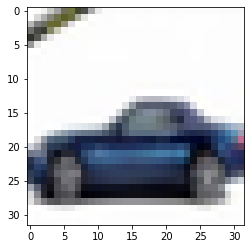

Starting image:


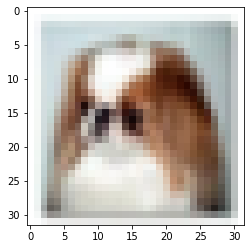

Adversarial Example:


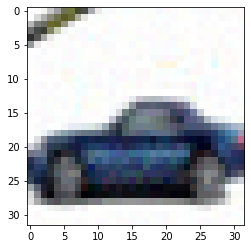

Perturbation Heat Map:


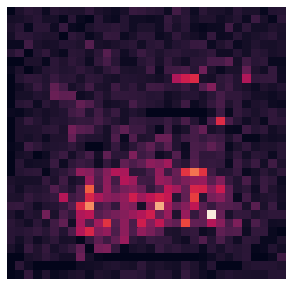

In [19]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [20]:
DRambH = Dt

In [21]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

- sample ID: 105
- ground-truth: 1 
- target label: 5 
- AdvEx label: 5
- L2 dist:0.9589738249778748


### 4b. RamBoAttack (SignOPT) Evaluation

In [22]:
i = 2#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [23]:
attack_mode = 'RBS' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 50000
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

Targeted attack - Source: 1 and Target: 5 - pred y0: tensor([1], device='cuda:0') - pred yt: tensor([5], device='cuda:0')
--------> Found distortion 11.6200
==========> Found best distortion 11.6200 in 0.0314 seconds using 22 queries
Iteration   1 distortion 9.2015 num_queries 373
Iteration  11 distortion 3.9571 num_queries 4240
Iteration  21 distortion 3.4252 num_queries 7691

 break due to slow convergence and group dim = 1!


Adversarial Example Found Successfully: distortion 3.4252 target 5 queries 7691 LS queries 3469 
Time: 18.0082 seconds
Module 1: Finished SignOPT

Qry# 0 ; l2 distance = 3.4251983165740967 ; adv label: 5
Qry# 1000 ; l2 distance = 2.504671573638916 ; adv label: 5
Qry# 2000 ; l2 distance = 2.094240665435791 ; adv label: 5
Qry# 3000 ; l2 distance = 1.8161439895629883 ; adv label: 5
Qry# 4000 ; l2 distance = 1.6032710075378418 ; adv label: 5
Qry# 5000 ; l2 distance = 1.446956753730774 ; adv label: 5
Qry# 6000 ; l2 distance = 1.3120777606964111 ; adv label: 5
Qry# 7

Source image:


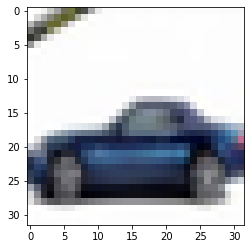

Starting image:


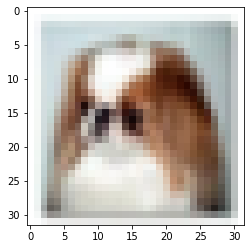

Adversarial Example:


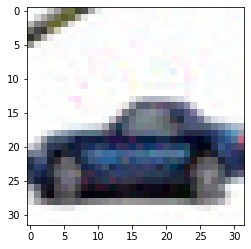

Perturbation Heat Map:


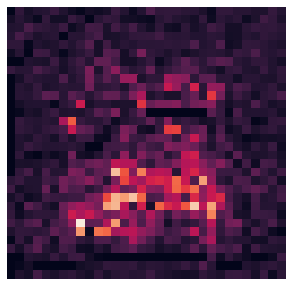

In [24]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [25]:
DRambS = Dt

In [26]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

- sample ID: 105
- ground-truth: 1 
- target label: 5 
- AdvEx label: 5
- L2 dist:1.0529546737670898


### 6. Plot Distortion vs Queries

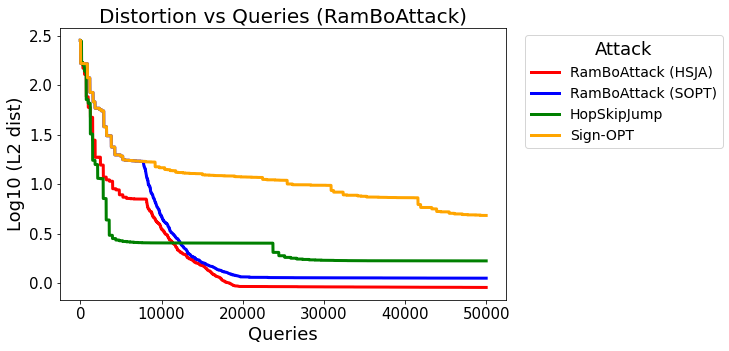

In [27]:
nq = query_limit
q = np.arange(nq)
df = pd.DataFrame({'qry':q,'dRambH':np.log(DRambH[:query_limit]),
                   'dRambS':np.log(DRambS[:query_limit]),
                   'dHsja':np.log(DHsja[:query_limit]),
                  'dSopt':np.log(DSopt[:query_limit])})

fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
f = sns.lineplot(x = 'qry', y = 'dRambH',ax=ax,linewidth = 3, color = 'red',label = 'RamBoAttack (HSJA)',data=df)
f = sns.lineplot(x = 'qry', y = 'dRambS',ax=ax,linewidth = 3, color = 'blue',label = 'RamBoAttack (SOPT)',data=df)
f = sns.lineplot(x = 'qry', y = 'dHsja',ax=ax,linewidth = 3, color = 'green',label = 'HopSkipJump',data=df)
f = sns.lineplot(x = 'qry', y = 'dSopt',ax=ax,linewidth = 3, color = 'orange',label = 'Sign-OPT',data=df)

f.axes.set_title("Distortion vs Queries (RamBoAttack)",fontsize=20)
f.set_xlabel("Queries",fontsize=18)
f.set_ylabel("Log10 (L2 dist)",fontsize=18)
f.tick_params(labelsize=15)
#plt.legend(labels=['RamBoAttack (HSJA)'])
plt.legend(title='Attack', fontsize='14', title_fontsize='18',bbox_to_anchor= (1.5,1))
plt.show()